# CST example

A Continuous Stirred Tank to be identified from input-output data

In [1]:
import numpy as np
from utils import plot_comparison

from sippy_unipi import SS_Model, system_identification
from sippy_unipi.datasets import gen_gbn_seq, gen_rw_seq, white_noise_var
from sippy_unipi.evaluate import validation
from sippy_unipi.ss import lsim_process_form
from sippy_unipi.typing import IOMethods

seed = 0
np.random.seed(seed)

In [2]:
ts = 1.0  # [min]
tfin = 1000
npts = int(tfin // ts) + 1
Time = np.linspace(0, tfin, npts)

## Data

In [3]:
V = 10.0  # tank volume [m^3]         --> assumed to be constant
ro = 1100.0  # solution density [kg/m^3] --> assumed to be constant
cp = 4.180  # specific heat [kJ/kg*K]    --> assumed to be constant
# latent heat   [kJ/kg]     --> assumed to be constant (Tvap = 100°C, Pvap = 1atm)
Lam = 2272.0
# initial conditions
# Ca_0
# Tin_0

## Variables

4 Inputs<br>
- as v. manipulated<br>
Input Flow rate Fin           [m^3/min]<br>
Steam Flow rate W             [kg/min]<br>
- as disturbances<br>
Input Concentration Ca_in     [kg salt/m^3 solution]<br>
Input Temperature T_in        [°C]<br>
U = [F, W, Ca_in, T_in]

In [4]:
m = 4

2 Outputs<br>
Output Concentration Ca       [kg salt/m^3 solution]  (Ca = Ca_out)<br>
Output Temperature T          [°C]                    (T = T_out)<br>
X = [Ca, T]

In [5]:
p = 2

### Function with Nonlinear System Dynamics

In [6]:
def Fdyn(X, U):
    # Balances

    # V is constant ---> perfect Level Control
    # ro*F_in = ro*F_out = ro*F --> F = F_in = F_out at each instant

    # Mass Balance on A
    # Ca_in*F - Ca*F = V*dCA/dt
    #
    dx_0 = (U[2] * U[0] - X[0] * U[0]) / V

    # Energy Balance
    # ro*cp*F*T_in - ro*cp*F*T + W*Lam = (V*ro*cp)*dT/dt
    #
    dx_1 = (ro * cp * U[0] * U[3] - ro * cp * U[0] * X[1] + U[1] * Lam) / (
        V * ro * cp
    )
    fx = np.append(dx_0, dx_1)
    return fx

Build input sequences

In [7]:
U = np.zeros((m, npts))

manipulated inputs as GBN<br>
Input Flow rate Fin = F = U[0]    [m^3/min]

In [8]:
prob_switch_1 = 0.05
F_min = 0.4
F_max = 0.6
Range_GBN_1 = (F_min, F_max)
[U[0, :], _, _] = gen_gbn_seq(
    npts, prob_switch_1, scale=Range_GBN_1, seed=seed
)
# Steam Flow rate W = U[1]          [kg/min]
prob_switch_2 = 0.05
W_min = 20
W_max = 40
Range_GBN_2 = (W_min, W_max)
[U[1, :], _, _] = gen_gbn_seq(
    npts, prob_switch_2, scale=Range_GBN_2, seed=seed
)

disturbance inputs as RW (random-walk)

Input Concentration Ca_in = U[2]  [kg salt/m^3 solution]

In [9]:
Ca_0 = 10.0  # initial condition
sigma_Ca = 0.01  # variation
U[2, :] = gen_rw_seq(npts, Ca_0, sigma=sigma_Ca, seed=seed)
# Input Temperature T_in            [°C]
Tin_0 = 25.0  # initial condition
sigma_T = 0.01  # variation
U[3, :] = gen_rw_seq(npts, Tin_0, sigma=sigma_T, seed=seed)

## Collect Data

Output Initial conditions

In [10]:
Caout_0 = Ca_0
Tout_0 = (ro * cp * U[0, 0] * Tin_0 + U[1, 0] * Lam) / (ro * cp * U[0, 0])
Xo1 = Caout_0 * np.ones((1, npts))
Xo2 = Tout_0 * np.ones((1, npts))
X = np.vstack((Xo1, Xo2))

Run Simulation

In [11]:
for j in range(npts - 1):
    # Explicit Runge-Kutta 4 (TC dynamics is integrateed by hand)
    Mx = 5  # Number of elements in each time step
    dt = ts / Mx  # integration step
    # Output & Input
    X0k = X[:, j]
    Uk = U[:, j]
    # Integrate the model
    for i in range(Mx):
        k1 = Fdyn(X0k, Uk)
        k2 = Fdyn(X0k + dt / 2.0 * k1, Uk)
        k3 = Fdyn(X0k + dt / 2.0 * k2, Uk)
        k4 = Fdyn(X0k + dt * k3, Uk)
        Xk_1 = X0k + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    X[:, j + 1] = Xk_1

Add noise (with assigned variances)

In [12]:
var = [0.001, 0.001]
noise = white_noise_var(npts, var, seed=seed)

Build Output

In [13]:
Y = X + noise

## Identificatino Stage (Linear Models)

Orders

In [14]:
na_ords = [2, 2]
nb_ords = [[1, 1, 1, 1], [1, 1, 1, 1]]
nc_ords = [1, 1]
nd_ords = [1, 1]
nf_ords = [2, 2]
theta = [[1, 1, 1, 1], [1, 1, 1, 1]]
# Number of iterations
n_iter = 300

IN-OUT Models: ARX - ARMAX - OE - BJ - GEN

In [15]:
identification_params: dict[
    IOMethods, tuple[tuple[list[int] | list[list[int]], ...], dict]
] = {
    "ARX": (
        (na_ords, nb_ords, theta),
        {
            "id_mode": "RLLS",
            "centering": "MeanVal",
        },
    ),
    "ARMAX": (
        (na_ords, nb_ords, nc_ords, theta),
        {
            "centering": "MeanVal",
            "max_iter": n_iter,
            "id_mode": "OPT",
        },
    ),
    "OE": (
        (nb_ords, nf_ords, theta),
        {
            "centering": "MeanVal",
            "max_iter": n_iter,
        },
    ),
    "BJ": (
        (nb_ords, nc_ords, nd_ords, nf_ords, theta),
        {
            "centering": "MeanVal",
            "max_iter": n_iter,
            "stab_cons": True,
        },
    ),
    "GEN": (
        (na_ords, nb_ords, nc_ords, nd_ords, nf_ords, theta),
        {
            "centering": "MeanVal",
            "max_iter": n_iter,
            "stab_cons": True,
            "stab_marg": 0.98,
        },
    ),
}

In [16]:
syss = []
for method, orders_params in identification_params.items():
    orders, params = orders_params
    sys_id = system_identification(Y, U, method, *orders, **params)
    syss.append(sys_id)

/app/sippy_unipi/io/opt.py:96: UserWarning: Reached maximum number of iterations
  warn("Reached maximum number of iterations")


SS - mimo<br>
choose method

In [17]:
method = "PARSIM_K"
order = 2
sys_id = system_identification(Y, U, method, order)
if not isinstance(sys_id, SS_Model):
    raise ValueError("SS model not returned")
# GETTING RESULTS (Y_id)
# SS
x_ss, Y_ss = lsim_process_form(
    sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0
)

In [18]:
Ys = [Y] + [getattr(sys, "y_id") for sys in syss] + [Y_ss]

PLOTS

Inputs

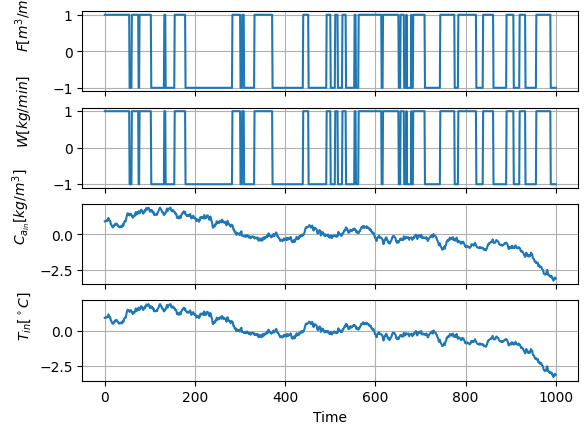

In [19]:
fig = plot_comparison(
    Time,
    U,
    [
        "$F [m^3/min]$",
        "$W [kg/min]$",
        "$C_{a_{in}} [kg/m^3]$",
        r"$T_{in} [^\circ{}C]$",
    ],
)

Outputs

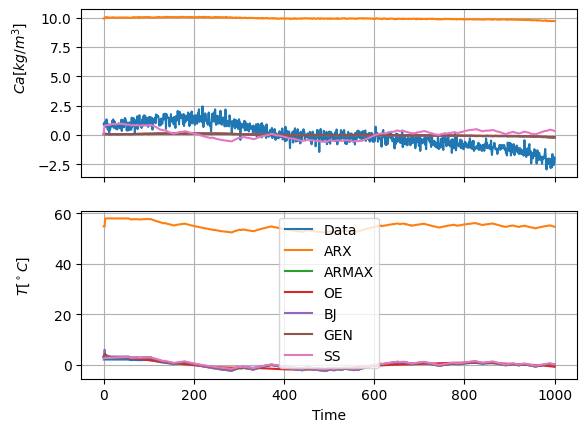

In [20]:
fig = plot_comparison(
    Time,
    Ys,
    ["$Ca [kg/m^3]$", r"$T [^\circ{}C]$"],
    legend=["Data", "ARX", "ARMAX", "OE", "BJ", "GEN", "SS"],
)

VALIDATION STAGE

Build new input sequences

In [21]:
U_val = np.zeros((m, npts))

manipulated inputs as GBN<br>
Input Flow rate Fin = F = U[0]    [m^3/min]

In [22]:
prob_switch_1 = 0.05
F_min = 0.4
F_max = 0.6
Range_GBN_1 = (F_min, F_max)
[U_val[0, :], _, _] = gen_gbn_seq(
    npts, prob_switch_1, scale=Range_GBN_1, seed=seed
)
# Steam Flow rate W = U[1]          [kg/min]
prob_switch_2 = 0.05
W_min = 20
W_max = 40
Range_GBN_2 = (W_min, W_max)
[U_val[1, :], _, _] = gen_gbn_seq(
    npts, prob_switch_2, scale=Range_GBN_2, seed=seed
)

disturbance inputs as RW (random-walk)<br>
Input Concentration Ca_in = U[2]  [kg salt/m^3 solution]

In [23]:
Ca_0 = 10.0  # initial condition
sigma_Ca = 0.02  # variation
U_val[2, :] = gen_rw_seq(npts, Ca_0, sigma=sigma_Ca, seed=seed)
# Input Temperature T_in            [°C]
Tin_0 = 25.0  # initial condition
sigma_T = 0.1  # variation
U_val[3, :] = gen_rw_seq(npts, Tin_0, sigma=sigma_T, seed=seed)

COLLECT DATA

Output Initial conditions

In [24]:
Caout_0 = Ca_0
Tout_0 = (ro * cp * U[0, 0] * Tin_0 + U[1, 0] * Lam) / (ro * cp * U[0, 0])
Xo1 = Caout_0 * np.ones((1, npts))
Xo2 = Tout_0 * np.ones((1, npts))
X_val = np.vstack((Xo1, Xo2))

Run Simulation

In [25]:
for j in range(npts - 1):
    # Explicit Runge-Kutta 4 (TC dynamics is integrateed by hand)
    Mx = 5  # Number of elements in each time step
    dt = ts / Mx  # integration step
    # Output & Input
    X0k = X_val[:, j]
    Uk = U_val[:, j]
    # Integrate the model
    for i in range(Mx):
        k1 = Fdyn(X0k, Uk)
        k2 = Fdyn(X0k + dt / 2.0 * k1, Uk)
        k3 = Fdyn(X0k + dt / 2.0 * k2, Uk)
        k4 = Fdyn(X0k + dt * k3, Uk)
        Xk_1 = X0k + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    X_val[:, j + 1] = Xk_1

Add noise (with assigned variances)

In [26]:
var = [0.01, 0.05]
noise_val = white_noise_var(npts, var, seed=seed)

Build Output

In [27]:
Y_val = X_val + noise_val

MODEL VALIDATION

IN-OUT Models: ARX - ARMAX - OE - BJ

In [28]:
YS = []
for i, sys in enumerate(syss):
    try:
        YS.append(validation(sys, U_val, Y_val, Time, centering="MeanVal"))
    except Exception as e:
        raise ValueError(
            f"Error in validation of model {[*identification_params.keys()][i]}:\n{e}"
        )
Yv_arx, Yv_armax, Yv_oe, Yv_bj, Yv_gen = (
    validation(sys, U_val, Y_val, Time, centering="MeanVal") for sys in syss
)
# SS
x_ss, Yv_ss = lsim_process_form(
    sys_id.A, sys_id.B, sys_id.C, sys_id.D, U_val, sys_id.x0
)
Ys_val = [Y_val] + [Yv_arx, Yv_armax, Yv_oe, Yv_bj, Yv_gen, Yv_ss]

PLOTS

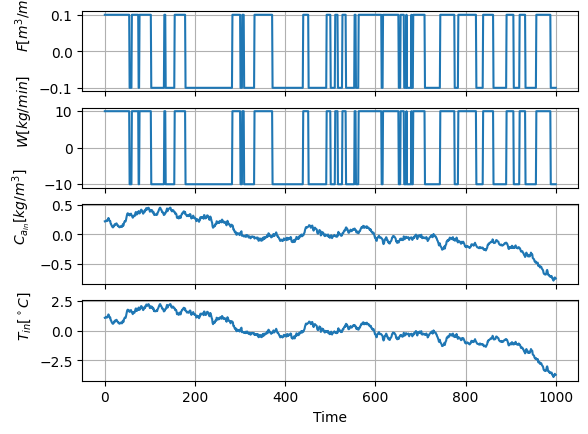

In [29]:
fig = plot_comparison(
    Time,
    U_val,
    [
        "$F [m^3/min]$",
        "$W [kg/min]$",
        "$C_{a_{in}} [kg/m^3]$",
        r"$T_{in} [^\circ{}C]$",
    ],
)

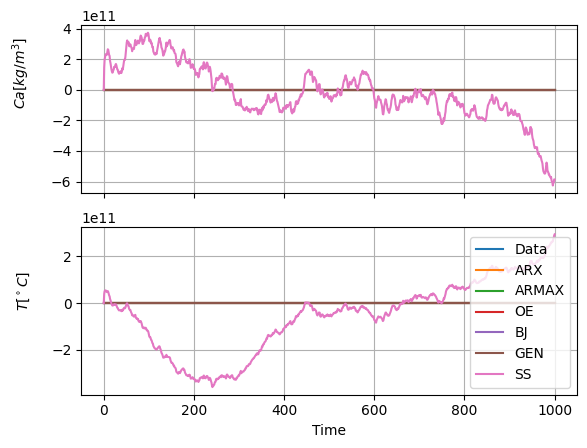

In [30]:
fig = plot_comparison(
    Time,
    Ys_val,
    ["$Ca [kg/m^3]$", r"$T [^\circ{}C]$"],
    legend=["Data", "ARX", "ARMAX", "OE", "BJ", "GEN", "SS"],
)